Exercicio 6 - SAA0336\
Nome: Alessandro Melo de Oliveira\
Nº USP: 10788662

In [925]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from sympy.plotting import plot
from numpy.polynomial import Polynomial
from scipy.integrate import quad

In [926]:
n2_limite = 4.3746
#n2_ultimate = 6.5619

b = 2260.5/1000 #envergadura [m]
S = (928554.75 / 1e6) # area da asa [m^2]

W = sum([1.10, 2.68, 2.68, 1.07, 0.84, 0.63, 0.45, 0.33, 0.22])
W += 54.84 + 60 + 100
L = n2_limite * W

V_2 = 29.5 # [m/s]

pressao_dinamica = 0.5 * 1.225 * (V_2**2)

In [927]:
nervuras = [0,1,2,3,4,5,6,7,8]

sustentacao = [155.78, 540.69, 638.48, 484.19, 436.33, 382.20, 294.12, 200.86, 83.25 ]
caso_de_carga_2 = pd.DataFrame()
caso_de_carga_2.set_index = nervuras
caso_de_carga_2.index.name = "Nervuras"
caso_de_carga_2['Sustentação [N]'] = [i/3 for i in sustentacao]

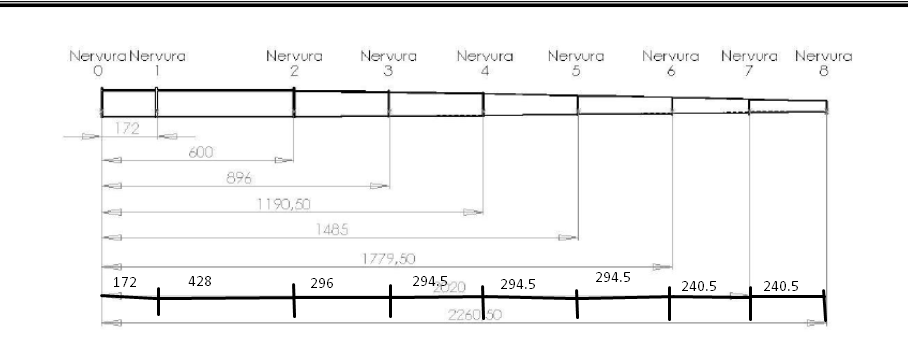

In [928]:
distancias = [0, 172, 600, 896, 1190.50, 1485, 1779.5, 2020, 2260.5] # a cortante é zero na ponta [mm]

def get_corda(x):
    x1,y1 = 600, 525
    x2,y2 = 2260.5, 214
    
    corda = np.interp(x, [x1,x2], [y1,y2])

    return corda

cordas = [round(get_corda(i),2) for i in distancias[3:]]
cordas = [525,525,525]  + cordas 

distancias_nervuras = pd.DataFrame()
distancias_nervuras.set_index = nervuras[::-1]
distancias_nervuras.index.name = "Estação nº"
distancias_nervuras['Yi [m]'] = [i/1000 for i in distancias][::-1]
distancias_nervuras['Comprimento da corda Ci [m]'] = [i/1000 for i in cordas][::-1]

In [929]:
forcas_momentos = pd.DataFrame()
forcas_momentos.set_index = nervuras[::-1]
forcas_momentos.index.name = "Estação nº"
forcas_momentos['Coeficiente de Força Cni'] = [0] + [.25] * (len(nervuras) - 1)
forcas_momentos['Força de Corte Vi [N]'] = [0] * len(nervuras)
forcas_momentos['Momento de Flexão [N.m]'] = [0] * len(nervuras)

In [930]:
tabela_completa = distancias_nervuras.join(forcas_momentos)
tabela_comparativa = tabela_completa.join(caso_de_carga_2)

In [931]:
tabela_completa

,Yi [m],Comprimento da corda Ci [m],Coeficiente de Força Cni,Força de Corte Vi [N],Momento de Flexão [N.m]
Estação nº,,,,,
0,2.2605,0.21400,0.00,0,0
1,2.0200,0.25904,0.25,0,0
2,1.7795,0.30409,0.25,0,0
3,1.4850,0.35925,0.25,0,0
4,1.1905,0.41440,0.25,0,0
5,0.8960,0.46956,0.25,0,0
6,0.6000,0.52500,0.25,0,0
7,0.1720,0.52500,0.25,0,0
8,0.0000,0.52500,0.25,0,0


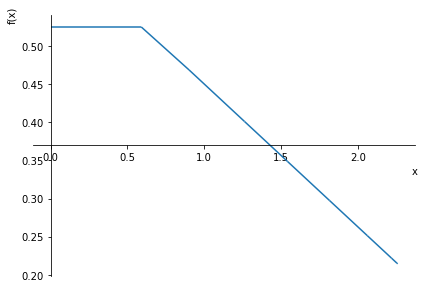

In [932]:
A,B, x, y = sp.symbols('A,B, x, y')

def corda_real():
    
    x = sp.Symbol('x')

    x1, y1 = 0.6, 0.525
    x2, y2 = b, 0.214

    coefficients = np.polyfit([x1,x2], [y1,y2], 1)

    slope = coefficients[0]
    intercept = coefficients[1]

    exp1 = 0.525
    exp2 = slope*x + intercept

    Cg = sp.Piecewise((exp1, (x >= 0)  & (x < 0.6)), ((exp2, (x > 0.6) & (x < b))))
    
    return Cg

plot_cg = plot(corda_real(), show = True)

In [933]:
def elipse_stender():
    
    A,B, x, y = sp.symbols('A,B,x, y')
    
    A = b # envergadura [m]
    B = S / (np.pi * A)
        
    A2B2 = (A**2) * (B**2) 
    X2B2 = (x**2) * (B**2)
    A2 = (A**2)
    
    y = sp.sqrt((A2B2 - X2B2)/(A2))
    Ce = 4 * y
    
    return Ce

In [934]:
Cg = corda_real()
Ce = elipse_stender()
Cs = sp.sqrt(Ce * Cg)

In [935]:
interval = np.linspace(0,b,500)

corda_elipse = [Ce.subs(x, i) for i in interval]
corda_real = [Cg.subs(x,i) for i in interval]
corda_stender = [Cs.subs(x,i) for i in interval]

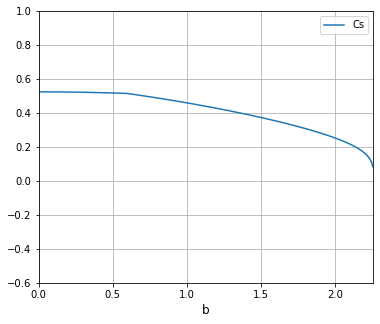

In [936]:
fig_cordas = plt.figure(figsize=(6,5))
# plt.plot(interval, corda_elipse, label = "Ce")
# plt.plot(interval, corda_real, label = "Cg")
plt.plot(interval, corda_stender, label = "Cs")
plt.xlabel("b", fontsize = 12)
plt.legend()
plt.grid()
plt.ylim([-0.6, 1])
plt.xlim([0, b])
plt.show()

In [970]:
def poly_stender():
    
    x = np.asarray(interval[:-1], dtype=np.float32)
    y = np.asarray(corda_stender[:-1], dtype=np.float32)
    
    poly = Polynomial.fit(x,y,deg = 15)
    
    return poly
    
poly_cs = poly_stender()

In [982]:
def li_stender():
    
    delta_Si_list = []
    Li_list = []
    
    dx_list = list(tabela_completa.iloc[:,0])[::-1]
    
    for i in range(0, len(dx_list) - 1):
        a = dx_list[i]
        b = dx_list[i+1]
        
        delta_Si = quad(poly_cs, a,b)[0]
        Li = (delta_Si/S)*L
        
        delta_Si_list.append(delta_Si)
        Li_list.append(Li)
        
    return Li_list[::-1]

In [986]:
Li = li_stender()

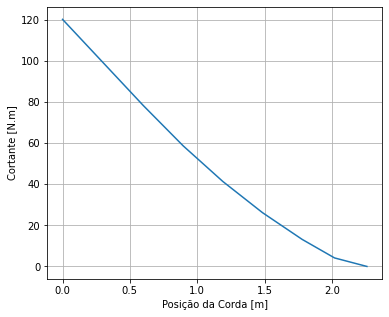

In [942]:
def numerico_cortante(tabela, graph = False):
    for i in range(1,len(tabela)):
        Ci = tabela.iloc[i,1]
        Cni = tabela.iloc[i,2]
        C_i_1 = tabela.iloc[i-1,1]
        Cn_i_1 = tabela.iloc[i-1,2]
        Vi_1 = tabela.iloc[i-1,3]
        Yi = tabela.iloc[i,0]
        Yi_1 = tabela.iloc[i-1,0]
        
        Vi = Vi_1 + 0.5 * pressao_dinamica * (Ci*Cni + C_i_1*Cn_i_1) * (Yi_1 - Yi)
        tabela.iloc[i,3] = Vi
        
    if graph == True:
        fig = plt.figure(figsize=(6,5))
        plt.plot(tabela.iloc[:,0], tabela.iloc[:,3])
        plt.xlabel("Posição da Corda [m]")
        plt.ylabel("Cortante [N.m]")
        plt.grid()
        plt.show()
        
numerico_cortante(tabela_completa, True)

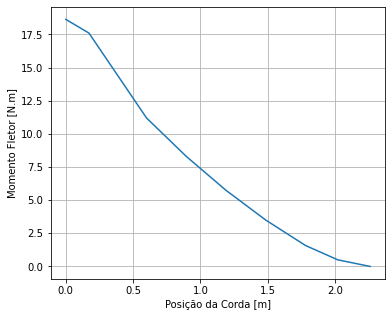

In [943]:
def numerico_momento(tabela, graph = False):
    for i in range(1, len(tabela)):
        Mi_1 = tabela_completa.iloc[i-1,4]
        Vi = tabela.iloc[i,3]
        Vi_1 = tabela.iloc[i-1,3]
        Yi = tabela.iloc[i,0]
        Yi_1 = tabela.iloc[i-1,0]
        
        Mi = Mi_1 + 0.5 * (Vi - Vi_1) * (Yi_1 - Yi)
        tabela.iloc[i,4] = Mi
        
    if graph == True:
        fig = plt.figure(figsize=(6,5))
        plt.plot(tabela.iloc[:,0], tabela.iloc[:,4])
        plt.xlabel("Posição da Corda [m]")
        plt.ylabel("Momento Fletor [N.m]")
        plt.grid()
        plt.show()

numerico_momento(tabela_completa, True)

In [944]:
tabela_completa

,Yi [m],Comprimento da corda Ci [m],Coeficiente de Força Cni,Força de Corte Vi [N],Momento de Flexão [N.m]
Estação nº,,,,,
0,2.2605,0.21400,0.00,0.000000,0.000000
1,2.0200,0.25904,0.25,4.150898,0.499145
2,1.7795,0.30409,0.25,13.174582,1.584243
3,1.4850,0.35925,0.25,26.190704,3.500868
4,1.1905,0.41440,0.25,41.371340,5.736216
5,0.8960,0.46956,0.25,58.716490,8.290289
6,0.6000,0.52500,0.25,78.331243,11.193273
7,0.1720,0.52500,0.25,108.274098,17.601044
8,0.0000,0.52500,0.25,120.307208,18.635891
